In [1]:
LABEL_FILE_PATH = 'song_labels.pkl'
MELSPEC_BASEPATH = 'melspec/'
NBEATS = 16
INPUTS_PER_BEAT = 16
NCHANNELS = 128

In [2]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import scipy
import pickle
import gzip
import os
import random
import math
import matplotlib.pyplot as plt
%matplotlib nbagg

/home/andy/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open(LABEL_FILE_PATH, 'rb') as fp:
    song_dict = pickle.load(fp)
songs = list(song_dict.keys())
nsongs = len(songs)
nsongs

115

In [4]:
ntrain = int(.8*nsongs)
ntrain

92

In [5]:
def choose_song():
    song = songs[random.randint(0, ntrain-1)]
    return(song)

In [6]:
def choose_tempo(song):
    tempo, compatible = random.sample(song_dict[song], 1)[0]
    return(tempo, compatible)

In [7]:
def get_cliplen( beats_per_minute ):
    nbeats = NBEATS
    samples_per_second = 22050
    seconds_per_minute = 60
    samples_per_hop = 256
    beats_per_second = beats_per_minute / seconds_per_minute
    hops_per_second = samples_per_second / samples_per_hop
    hops_per_beat = hops_per_second / beats_per_second
    return(nbeats*int(hops_per_beat))

In [8]:
def choose_clip(song, tempo):
    cliplen = get_cliplen(tempo)
    melspec_path = MELSPEC_BASEPATH + song + '_melspec.pkl.gz'
    with gzip.open(melspec_path,'rb') as fp:
        ms = pickle.load(fp)
    clip_start = random.randint(0, ms.shape[1]-cliplen-1)
    clip = ms[:,clip_start:clip_start+cliplen]
    return(clip)

In [9]:
def get_training_case():
    song = choose_song()
    tempo, compatible = choose_tempo(song)
    raw_clip = choose_clip(song, tempo)
    return(song, tempo, compatible, raw_clip)

In [10]:
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)

In [11]:
def resample_clip(raw_clip):  # Resample clip so time dimension has length NBEATS*INPUTS_PER_BEAT

    initial_length = raw_clip.shape[1]
    final_length = NBEATS*INPUTS_PER_BEAT

    # Will first upsample to common multiple of lengths, then downsample to final length
    maximum_length = lcm(initial_length, final_length)
    
    # Normalize time scale to make each observation at maximum_length equal one (pseudo-)second
    ticks_per_pseudo_second = 10**9  # conversion factor from integer to pandas seconds
    max_time = maximum_length*ticks_per_pseudo_second
    clip_time = pd.to_datetime(np.arange(0, max_time, max_time/initial_length))
    
    # Convert data to pandas time series
    df = pd.DataFrame(raw_clip.transpose(), index=clip_time)
    
    # Frequency corresponding to output length, given time normalizatoin
    outfreq = str(int(maximum_length/final_length))+'S'
    
    # Upsample, then downsample
    df = df.resample('S').interpolate().resample(outfreq).mean()
    
    # Convert back to numpy format
    clip = df.values.transpose()

    return(clip)

In [12]:
def clip_to_tf_input(clip):  # Convert resampled clip to channels-last CNN input format
    return(clip.transpose().reshape(INPUTS_PER_BEAT, NBEATS, NCHANNELS))

In [22]:
song, tempo, compatible, clip = get_training_case()

In [23]:
song, tempo, compatible

('HowDoIMakeYou', 83, True)

In [24]:
clip.shape

(128, 992)

In [25]:
c = clip_to_tf_input(resample_clip(clip))
c.shape

(16, 16, 128)

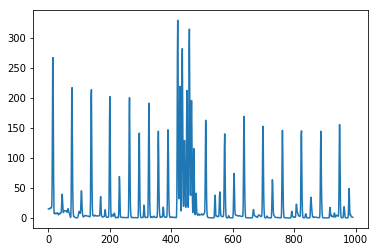

In [26]:
plt.plot(range(clip.shape[1]),clip[5,:])

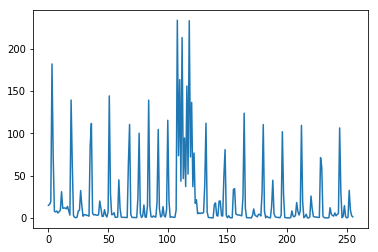

In [27]:
plt.plot(range(c.shape[0]*c.shape[1]),c[:,:,5].reshape(c.shape[0]*c.shape[1]))

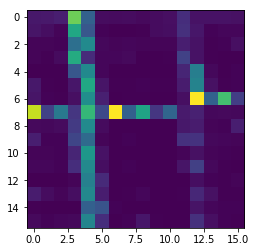

In [28]:
plt.imshow(c[:,:,5])

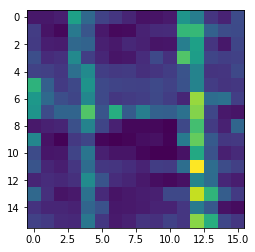

In [29]:
plt.imshow(c.mean(axis=2))

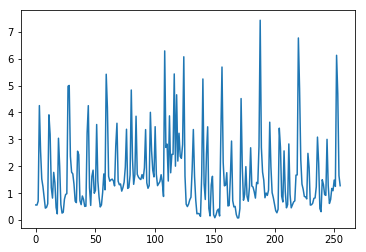

In [30]:
cmean = c.mean(axis=2)
plt.plot(range(cmean.shape[0]*cmean.shape[1]),cmean.reshape(cmean.shape[0]*cmean.shape[1]))